# Models Exploration

Having trained the model in the previous model, it is the time for us to inspect our top models. There are two main things happening in this notebook:

1. [Visualize how the model 'see' the pictures](#Visualizing-Models)
2. [Compare the model on real life footages](#Model-Comparison)

Let's get into it!

## Import Packages

In [5]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray, expand_dims
import keras
import tensorflow as tf
import numpy as np
from imutils.video import VideoStream
import imutils
import time
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot as plt
from IPython.display import Video

### Loading the Top Models

In [6]:
model_vgg16 = keras.models.load_model('./saved_models/model_vgg16.h5')
model_vggface = keras.models.load_model('./saved_models/model_vggface_fine.h5')
model_custom_2 = keras.models.load_model('./saved_models/model_custom_2.h5')
model_custom_3 = keras.models.load_model('./saved_models/model_custom_3.h5')

## Visualizing Models

We now understand the 'goodness' of our model. However, we still cannot visualize how each of the model is able to extract the facial landmarks from the expression and identify the underlying emotion of the subject. Therefore, in this chapter, we will attempt to visualize what the model 'sees' to identify emotion. 

Note that the code below are inspired by an article by [Jason Brownlee](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/) posted at machinelearningmastery.com. 

In [7]:
# Define a function to print convolution layers and their corresponding index
def conv_layer_finder(model):
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # summarize output shape
        print(i, layer.name, layer.output.shape)
        
# Define a function to print feature maps
def feature_maps_printer(model, layer_no, img_path, square_size):
    model_v = Model(inputs=model.inputs, outputs=model.layers[layer_no].output)
    img = load_img(img_path, target_size=(48, 48))
    img = img_to_array(img)
    img = expand_dims(img, axis=0)
    feature_maps = model_v.predict(img)
    square = square_size
    fig, ax = plt.subplots(ncols=square, nrows=square, figsize=(15, 15))
    ax = ax.ravel()
    for i in range(square*square):
        ax[i].imshow(feature_maps[0, :, :, i], cmap='gray')
        ax[i].axes.xaxis.set_visible(False)
        ax[i].axes.yaxis.set_visible(False)

We know that CNN works by extracting simpler features such as object boundaries on earlier layers and grow into a more complex shape like feature on the deeper layers. Let's observe this by using an example picture.

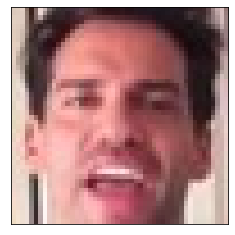

In [8]:
img = load_img('./media/example_picture.jpg', target_size=(48, 48))
plt.imshow(img)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

Let's observe the convolution layers on our custom made model, Custom Model 2. 

In [9]:
model = keras.models.load_model('./saved_models/model_custom_2.h5')
conv_layer_finder(model)

0 conv_layer_1a (None, 46, 46, 64)
1 conv_layer_1b (None, 44, 44, 64)
5 conv_layer_2a (None, 20, 20, 128)
6 conv_layer_2b (None, 18, 18, 128)
10 conv_layer_3a (None, 7, 7, 256)
11 conv_layer_3b (None, 5, 5, 256)


Custom Model 2 has 6 convolution layers. Normally, the deeper the layer goes, the smaller the feature size but increases in depth. For instance, the first convolution layer block (output of conv_layer_1a) has 46x46 pixels feature size with 64 filters (depth). The subsequent layer block (conv_layer_2a) has only 20x20 pixels feature size but with 128 filters (depth). 

Subsequently, we will print 25 feature space corresponding to the first 25 filters on the selected layer.

**1. Output of Layer 0 (first 25 filters)**

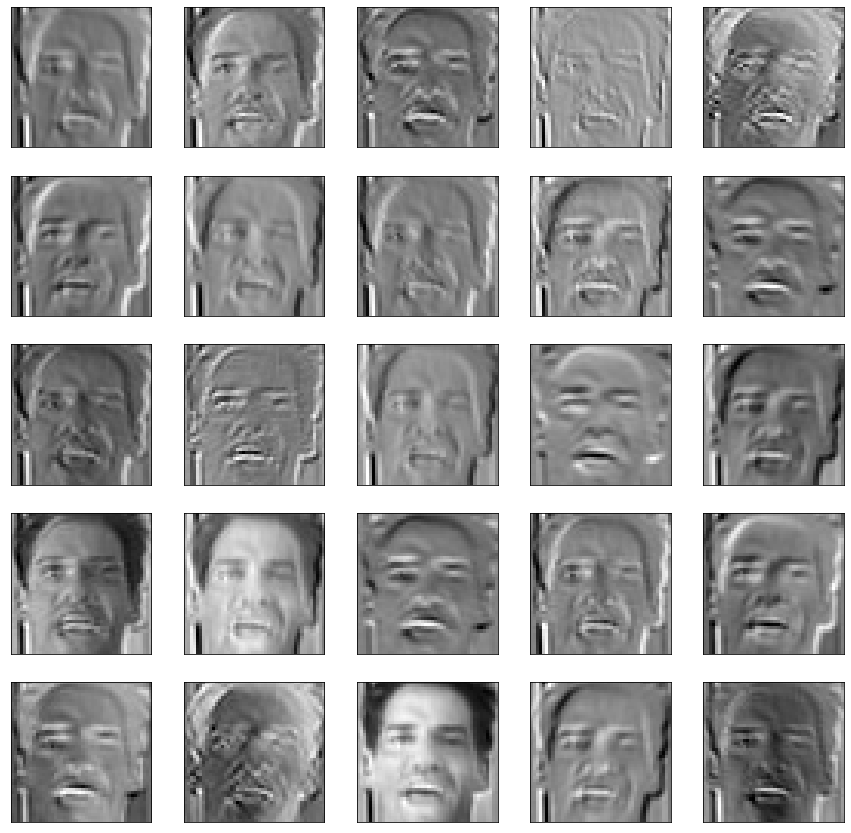

In [10]:
feature_maps_printer(model, 0, './media/example_picture.jpg', 5)

**Observations:**
- We can observe that the first layer of convolution block manage to obtain the outline of the face. 

**2. Output of Layer 6 (first 25 filters)**

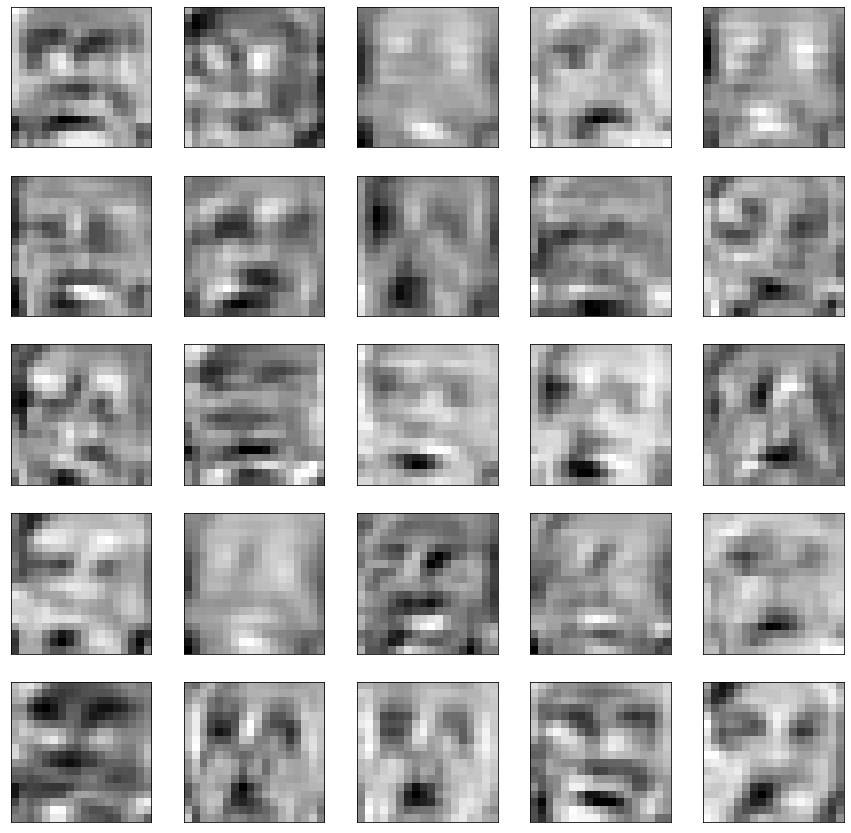

In [11]:
feature_maps_printer(model, 6, './media/example_picture.jpg', 5)

**Observations:**
- Moving forward to layer number 5 (output of 2nd convolutional block), we can observe a more 'abstract' representation of faces. 
- Despite havin a significantly lower pixel counts compared to the earlier convolutional block, this layer outlines the facial landmarks such as eyes, nose and mouth. 

**3. Output of Layer 11 (first 25 filters)**

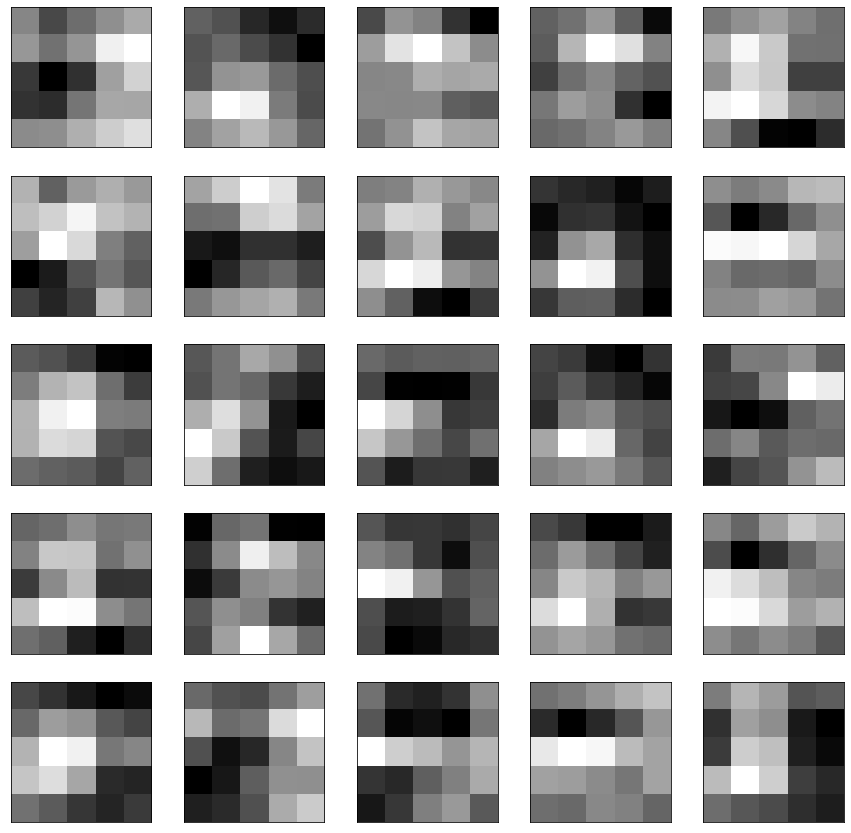

In [12]:
feature_maps_printer(model, 11, './media/example_picture.jpg', 5)

**Observations:**
- This is where it gets more interesting as the original image are only represented by many (256 to be exact) 5x5 pixels representation. This is where the face does not look like a face anymore! However, these are the pattern that the neural net requires to perform the classification on the densely connected network subsequently. 

## Model Comparison

In the previous notebook, the models performance are gauge based on the validation dataset which comes together with the MMA Facial Emotion Recognition by Kaggle. In this notebook, we will observe the model performance based on the actual image or video of people. 

Pictures comes in different sizes and shapes. Therefore, we need to preprocess the picture before we can perform classification and print the result. The flow of work is as follows:
1. Load the image to notebook
2. Find the face within the image
3. Crop the image only on the face
4. Resize the image to fit 48x48 that our model can consume
5. Obtain prediction from the model
6. Display the picture and prediction
7. Eyeball the goodness of each model's prediction based on our judgement

From all the steps above, the most troublesome one is to find a face within the image as it cannot be hard-coded. Luckily, there are many pretrained model and library out there that can be used to identify the boundary of faces within an image. The one that I used for this project is from OpenCV ([source](https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml)). 

On top of that, the function 'detect_identity_picture' below is adopted from code obtained from [source](https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php).

In [13]:
class_to_label = {0: 'angry', 1: 'happy', 2: 'sad'}

def detect_identify_picture(filename, models, model_names, show_face_no):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    img = cv2.imread(filename)
    
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    results = face_cascade.detectMultiScale(gray, 1.1, 4)
    root_resolution = (img.shape[0] * img.shape[1])**(0.5)
    box_thickness = int(root_resolution/400)

    if len(results)!=0:
        for face_no, result in enumerate(results):
            x, y, w, h = result

            x1 = x
            x2 = x+w
            y1 = y
            y2 = y+h

            ori_face = img[y1:y2, x1:x2]
            image = Image.fromarray(ori_face)
            image = image.resize((48, 48))
            face_array = asarray(image)
            
#             print("Face no: {}".format(face_no), end='. ')
            for model, model_name in zip(models, model_names):
                predict_function(model_name, model, face_array)
                
#             print("")
            if show_face_no:
                cv2.putText(img, str(face_no + 1), (x1+5, y2-20), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), box_thickness)
            
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.axis('off')
    ax.imshow(img)

In [14]:
def predict_function(model_name, model, array):
    pred = model.predict(tf.constant(array.reshape(1, 48, 48, 3)))
    label = class_to_label[np.argmax(pred)]
    print("{}> {}\t: {}%".format(model_name, label, np.round(max(pred[0])*100,1)))

In [15]:
models = [model_vgg16, model_vggface, model_custom_2, model_custom_3]
model_names = ['VGG16\t\t\t\t', 'VGGFace\t\t\t\t', 'Custom 2: Using BN\t\t', 'Custom 3: After Random Search\t']

### Classification from Picture

#### Sad Pictures

VGG16				> sad	: 68.3%
VGGFace				> sad	: 71.3%
Custom 2: Using BN		> sad	: 69.2%
Custom 3: After Random Search	> sad	: 79.5%


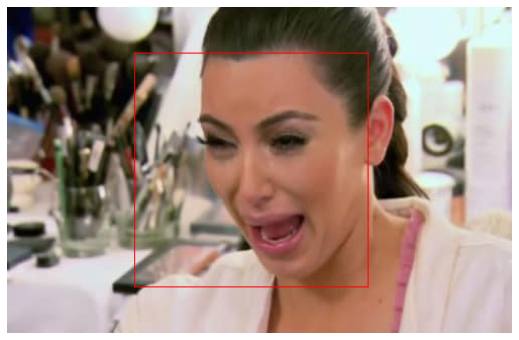

In [22]:
detect_identify_picture('./media/kk-crying.jpeg', models, model_names, False)

VGG16				> angry	: 66.2%
VGGFace				> sad	: 86.8%
Custom 2: Using BN		> sad	: 93.4%
Custom 3: After Random Search	> sad	: 97.9%


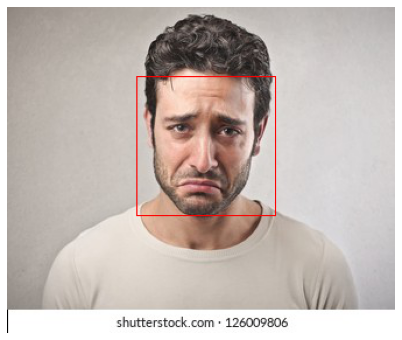

In [23]:
detect_identify_picture('./media/sad-face.jpeg', models, model_names, False)

VGG16				> sad	: 66.0%
VGGFace				> sad	: 97.7%
Custom 2: Using BN		> happy	: 100.0%
Custom 3: After Random Search	> happy	: 58.6%


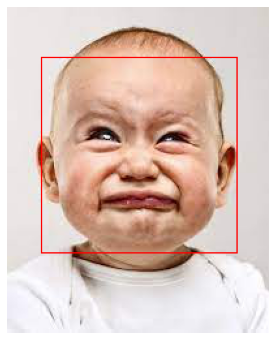

In [24]:
detect_identify_picture('./media/sad_baby.jpeg', models, model_names, False)

#### Happy Pictures

VGG16				> sad	: 68.4%
VGGFace				> happy	: 99.5%
Custom 2: Using BN		> happy	: 99.7%
Custom 3: After Random Search	> happy	: 82.1%


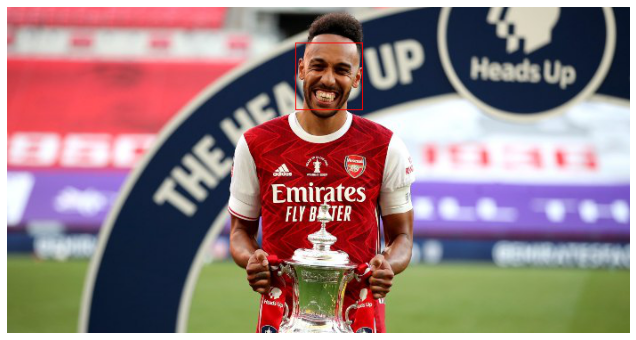

In [25]:
detect_identify_picture('./media/auba.jpeg', models, model_names, False)

VGG16				> happy	: 77.5%
VGGFace				> happy	: 100.0%
Custom 2: Using BN		> happy	: 100.0%
Custom 3: After Random Search	> happy	: 100.0%


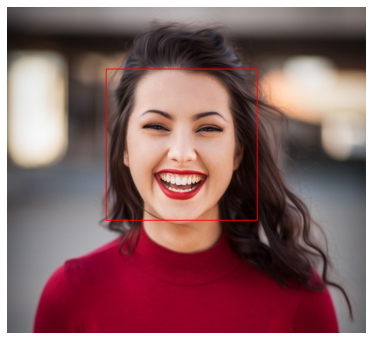

In [26]:
detect_identify_picture('./media/happy-face.jpg', models, model_names, False)

VGG16				> happy	: 77.5%
VGGFace				> happy	: 100.0%
Custom 2: Using BN		> happy	: 100.0%
Custom 3: After Random Search	> happy	: 99.8%


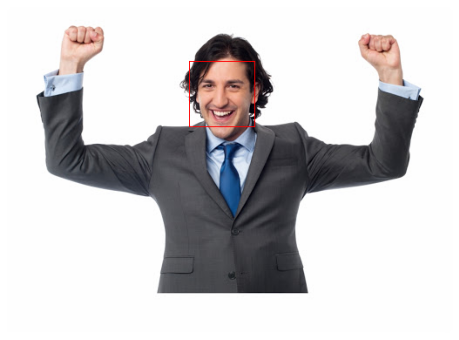

In [27]:
detect_identify_picture('./media/happy-man.jpeg', models, model_names, False)

#### Angry Pictures

VGG16				> angry	: 99.1%
VGGFace				> angry	: 100.0%
Custom 2: Using BN		> angry	: 47.1%
Custom 3: After Random Search	> angry	: 60.5%


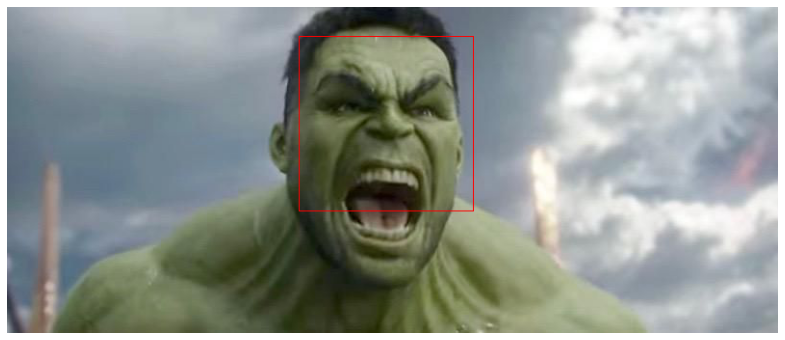

In [28]:
detect_identify_picture('./media/hulk.jpeg', models, model_names, False)

VGG16				> angry	: 100.0%
VGGFace				> angry	: 100.0%
Custom 2: Using BN		> angry	: 96.0%
Custom 3: After Random Search	> angry	: 97.4%


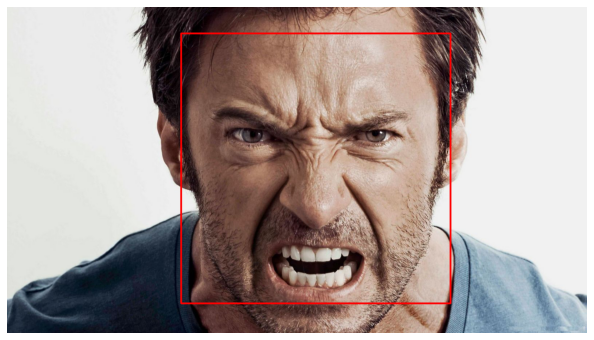

In [29]:
detect_identify_picture('./media/wolv-angry.jpeg', models, model_names, False)

VGG16				> angry	: 87.9%
VGGFace				> angry	: 100.0%
Custom 2: Using BN		> angry	: 73.0%
Custom 3: After Random Search	> angry	: 75.1%


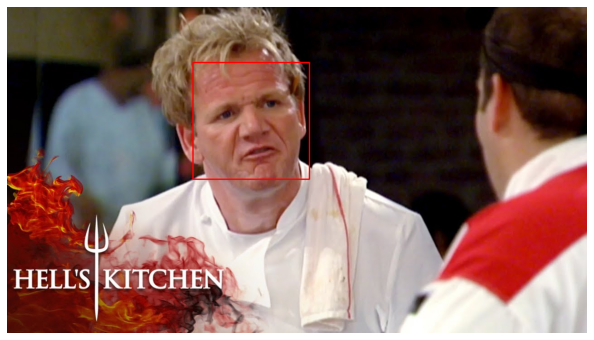

In [30]:
detect_identify_picture('./media/gr-angry.jpeg', models, model_names, False)

### Classification from Video

The classifier also able to detect emotion on video footage as video is just a combination of moving frames. In this chapter, I write two functions to detect emotion on a pre-recorded video (detect_identify_video) and on webcam (detect_identify_cam). 

#### Prerecorded Video

In [31]:
def detect_identify_video(model):
    vcap = cv2.VideoCapture('./media/dsi20.mov')
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640,  480))
    
    while(vcap.isOpened()):
        ret, frame = vcap.read()
        
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
            
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        results = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        for result in results:
            x, y, w, h = result
            x1 = x
            x2 = x+w
            y1 = y
            y2 = y+h

            ori_face = frame[y1:y2, x1:x2]
            image = Image.fromarray(ori_face)
            image = image.resize((48, 48))
            face_array = asarray(image)

            pred = model.predict(tf.constant(face_array.reshape(1, 48, 48, 3)))
            label = class_to_label[np.argmax(pred)]
            label_txt = "{}: {}%".format(label, np.round(max(pred[0])*100,1))

            cv2.putText(frame, label_txt, (x1+2, y2-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
        cv2.imshow('frame',frame)
        
        out.write(frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

In [24]:
detect_identify_video(model_vggface)

#### Webcam Footage

This is a footage of General Assembly DSI20 class taken on the 20 April of 2021. Only half of people in the class are showing their full face in the camera (some are half-blocked). Therefore, only some faces are detected by the cv2 classifier.

The following function is written to identify facial expression in front of the webcam. Yes, it will detect your very face!

In [32]:
def detect_identify_cam(model):
    vs = VideoStream(src=0).start()
    
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    while True:
        frame = vs.read()
        frame = imutils.resize(frame, width=400)
        
        # Convert into grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Detect faces
        results = face_cascade.detectMultiScale(gray, 1.1, 4)

        if len(results)==1:
            x, y, w, h = results[0]
            x1 = x
            x2 = x+w
            y1 = y
            y2 = y+h

            ori_face = frame[y1:y2, x1:x2]
            image = Image.fromarray(ori_face)
            image = image.resize((48, 48))
            face_array = asarray(image)

            pred = model.predict(tf.constant(face_array.reshape(1, 48, 48, 3)))
            label = class_to_label[np.argmax(pred)]
            label_txt = "{}: {}%".format(label, np.round(max(pred[0])*100,1))

            cv2.putText(frame, label_txt, (x1+2, y2-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        

        cv2.imshow("Frame", frame)

        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

In [33]:
detect_identify_cam(model_vggface)

##### Angry - Happy Face

In [34]:
Video("./media/angry-happy.mov")

**Observations:**
- I performed a mini-experiment here to 'trick' the model to identify my face as angry or happy just by changing my mouth (I tried my best not to move any other part of my face). As we can see, the model can differentiate angry and happy face by observing the mouth shape.

##### Angry - Sad Face

In [35]:
Video("./media/angry-sad.mov")

**Observations:**
- My experiment continues. I tried to get either angry or sad face by changing how I position my eyebrow. When I squeeze them higher, the model tends to think that it looks more like a sad face! Interesting finding. 
- Also, when I tilt my head higher without moving a muscle on my face, the model change its prediction from angry to sad. 

##### Mixed Face

In [36]:
Video("./media/mixed.mov")

**Observations:**
- Now is the time to show some facial expression free style. Generally the model is able to detect my expression according to what I intend to show it. 

## Conclusion

We started with the problem statement of building a classifier model to identify human emosion based on facial expression. As hard-coding this problem will be nearly impossible, the most common solution for this problem is by building a Convolutional Neural Network. In total, there are 6 models trained consisting of:

|  No. |   Model Name   |     Type     | Best Validation Accuracy | Remarks                                                     |
|:----:|:--------------:|:------------:|:------------------------:|-------------------------------------------------------------|
|  0.  |    Baseline    |      -       |           33.3%          | Select all data to be majority class                        |
|  1.  |      VGG16     |  Pre-trained |           63.5%          | Pretrained model                                            |
|  2.  |     VGGFace    |  Pre-trained |           75.5%          | VGG16 trained on facial dataset                             |
|  3.  |    ResNet50    |  Pre-trained |            50%           |                                                             |
|  4.  | Custom Model 1 | Custom Built |           34.9%          | Ended up categorizing all data into happy faces                        |
|  5.  | Custom Model 2 | Custom Built |           65.6%          | CNN with batch normalization                                |
|  6.  | Custom Model 3 | Custom Built |           66.7%          | Find best combination of hyperparameter using keras tuner.  |

**Pre-trained Models**

The first three model (excluding the baseline model) is trained based on existing well-established model that is adapted for our use. The improvement is made by retraining the last block for every convolutional network for a few epochs until validation accuracy stops improving for 6 epochs in a row. As predicted, VGGFace outperforms all the model as it was pre-trained on millions of facial pictures (VGG Face Dataset). 

**Custom Built Models**

Subsequently, we also developed a custom built model with 3 convolution blocks (each block consisting of 2 convolution layers), followed by 2 block of fully-connected network and 1 prediction layer. Interesting to note that initially the model (Custom Model 1) performs very badly (only performs as well as the baseline model) due to exploding gradient problem. The next iteration of the model (Custom Model 2) possess exactly the same network but with addition of Batch Normalization layer in between of the dense network. This model performs significantly better. Custom Model 3 inherits structure from the previous two models but with number of filter, dense unit and dropout decided by keras tuning random search. It improves the validation accuracy marginally. 

**Visualization of Models**

Custom Model 2 was dissected to understand how it manages to extract facial landmarks to identify emotion from facial expression. Some observations:
- Earlier layer extract outlines of the image. Some pictures still retain some degree of color of the image.
- At the middle layers, pictures have been transformed into facial landmarks such as mouth, nose, eyes, etc.
- Finally, at the last layers, picture has been totally reconstructed beyond human comprehension. This output is used as the training material for the downstream neural networks.

**Model Performance on Real Footage**

The best model (VGG Face) is tested to identify real footages. The model is able to detect facial expression based on different shape in mouth, eyebrow and head positioning. Functions to detect photo and videos are also written for trial.

## Model Limitation and Recommendations

Although the current model has performed fairly well under new footages, it still has some major limitations:

1. Currently, the model is limited to identifying three emotions, angry, sad and happy. However, there are many other emotions such as disgust, fear, neutral, etc. that human naturally shows on daily basis. On top of these basic emotions, there are much more complex emotions such as confused, embarrassed, etc. Building a model to capture these expressions are much more useful for deployment, i.e. student monitoring or customer service quality monitoring system. 

2. The current models are trained with low quality images with many questionable labelling, some even does not contain a face! With a cleaner and better resolution pictures, the model can have a better accuracy score on a new facial footage. 

3. With the increasing mask usage during the pandemic, it will be useful to train a model based on masked images. This can either be done by collecting actual mask pictures or by covering facial features using a digital mask [artificially](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/). 